# Brain Tumor Segmentation
This notebook builds end-to-end image classifier and image segmentation models using TensorFlow 2.0.

## 1. Problem
Identifying from the MRI scans whether the brain tumor exists or not. And if the tumor is present, locate and segment the tumor accurately.

## 2. Data

We are using the TCGA (The Cancer Genome Atlas Program) dataset downloaded from The Cancer Imaging Archive website.

## 3. Evaluation

Our goal is to beat the scores of current research papers on Brain Tumor segmentation from MRI scans.

In 2021, Lucas Fidon, Sebastien Ourselin, and Thomas Vercauteren had used the nnUNet architecture-based model which had achieved an accuracy of 92% on the segmentation of the Brain Tumor.

So, our model needs to score an accuracy of more than 92%.

We are using Tversky accuracy and loss as evaluation metrics.

## 4. Features

Some information about the data:

* We're dealing with images (unstructured data), so it's probably best we use deep learning/transfer learning.
* There are 3929 MRI scan images of patients, out of which 2556 of them have tumor and 1373 patients have no tumor.
* We have split 85% of the data for training and 15% of data for testing.

## Importing Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
import datetime
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0e754f4b-c9aa-d4c2-d4e9-9af83c06c457)


In [ ]:
# Navigating to directory containing the dataset
%cd /content/drive/MyDrive/Brain Tumor Segmentation/Brain_MRI

/content/drive/MyDrive/Brain Tumor Segmentation/Brain_MRI


In [ ]:
# Creating a dataframe of data path and its corresponding mask
brain_df = pd.read_csv('data_mask.csv')

**Note**: `Mask` in case of Brain Tumor Segmentation refers to the coordinates of actual pixel values of the MRI scan where the tumor is located.

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [ ]:
brain_df.tail()

patient_id  \
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0

In [ ]:
# Check how many instances (patient records) are present in our dataset
len(brain_df)

3929

In [ ]:
# Checking what classes we are working with
brain_df["mask"].value_counts().index

Int64Index([0, 1], dtype='int64')

In [ ]:
# Check how many values of each class are present
# 0 - Tumor not detected
# 1 - Tumor detected

brain_df["mask"].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

We can see that in our dataset there are almost twice the number of people without tumor than there are with tumor.

## Visualizing the Data

In [ ]:
# Using plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=brain_df["mask"].value_counts().index,
                        y=brain_df["mask"].value_counts())])
fig.update_traces(marker_color="rgb(0,200,0)")
fig.show()

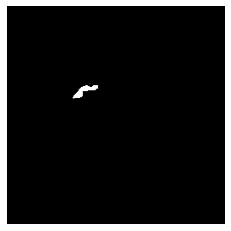

In [ ]:
# Checking out a random mask
plt.imshow(cv2.imread(brain_df.mask_path[623]))
plt.axis("off");

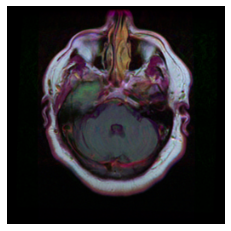

In [ ]:
# Checking out the MRI of the above mask
plt.imshow(cv2.imread(brain_df.image_path[623]))
plt.axis("off");

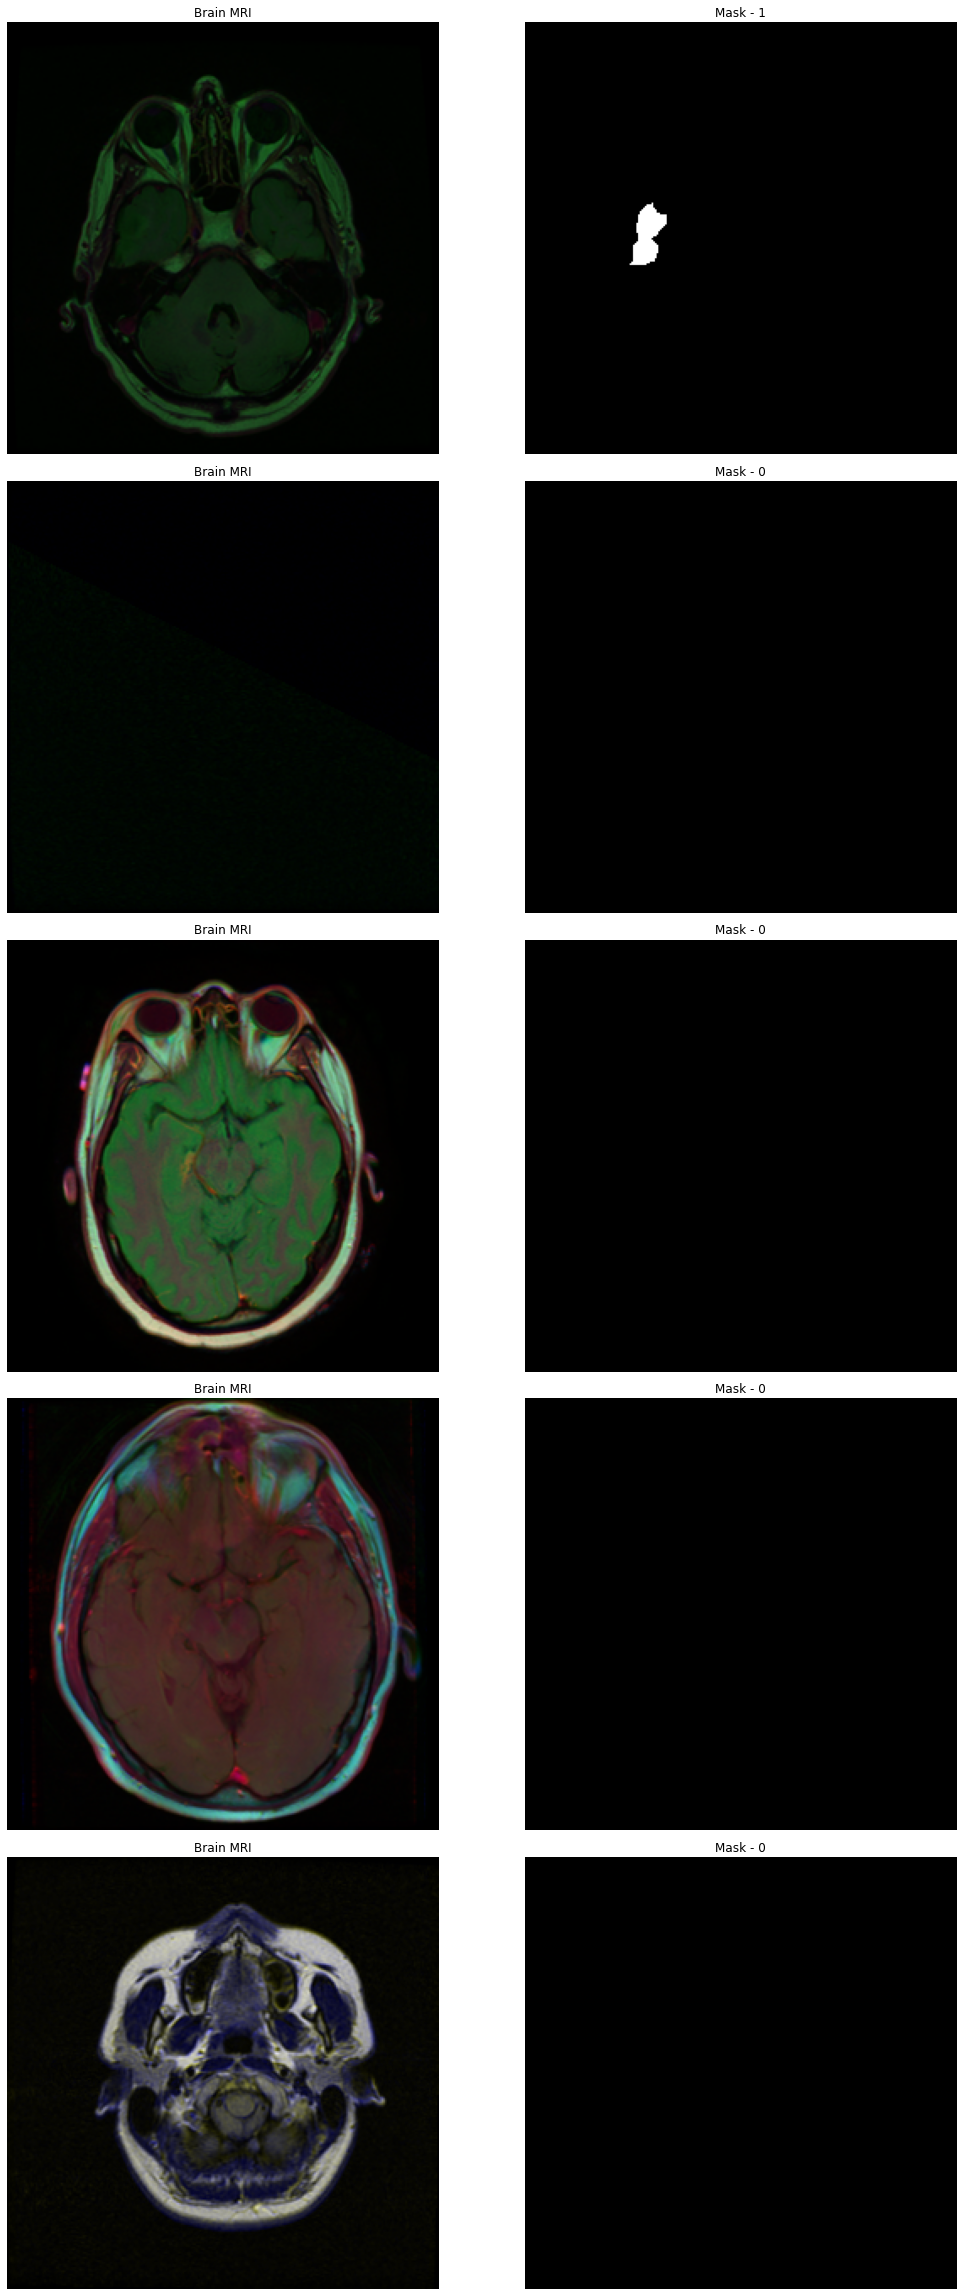

In [ ]:
# Visualizing the images (MRI and Mask) in the dataset separately
import random
fig, ax = plt.subplots(5, 2, figsize=(16,32))
count = 0
for x in range(5):
  i = random.randint(0, len(brain_df)) # select a random index
  ax[count][0].title.set_text("Brain MRI") # set title
  ax[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  ax[count][0].axis("off")
  ax[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  ax[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  ax[count][1].axis("off")
  count += 1

fig.tight_layout()

### Plotting randomly selected MRI scan images (label=1) with their corresponding mask

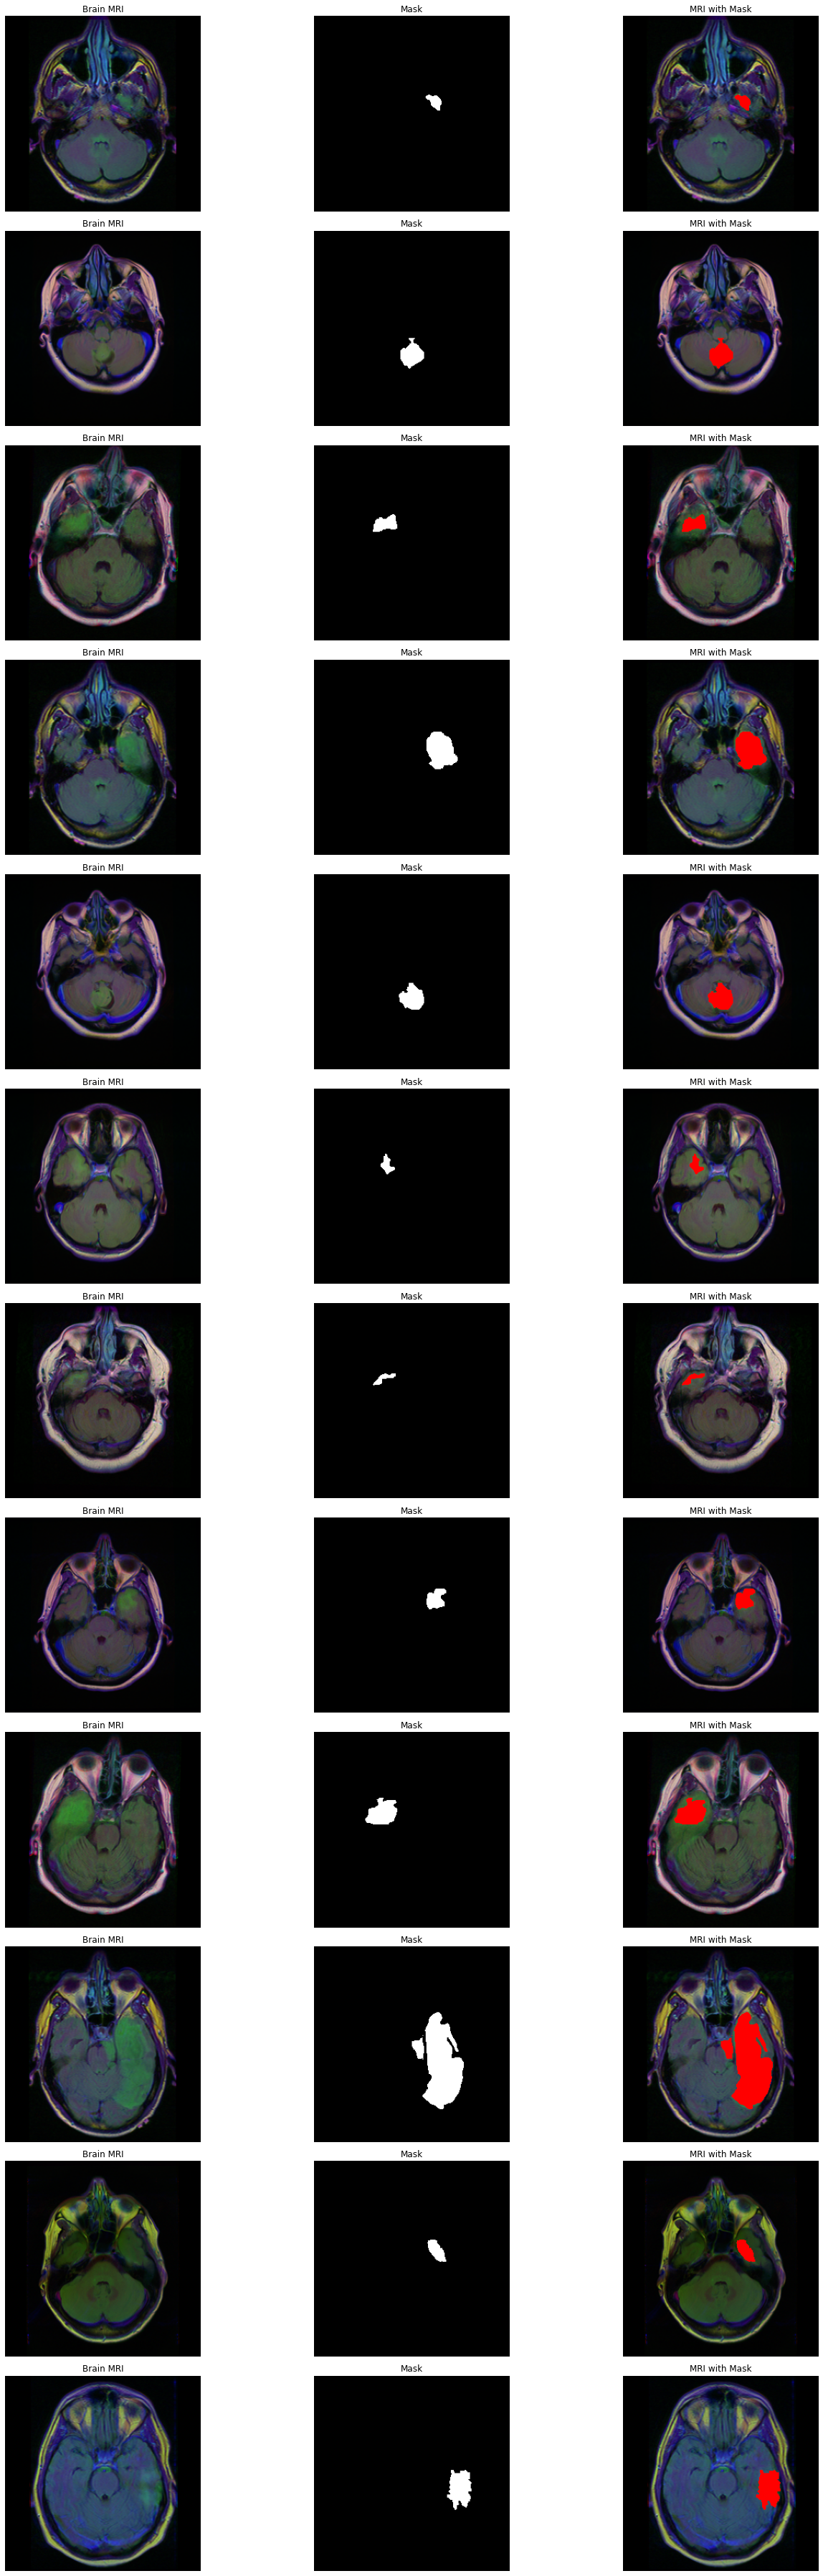

In [ ]:
count = 0
fig, ax = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df["mask"][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    ax[count][0].title.set_text("Brain MRI")
    ax[count][0].imshow(img)
    ax[count][0].axis("off")

    mask = io.imread(brain_df.mask_path[i])
    ax[count][1].title.set_text("Mask")
    ax[count][1].imshow(mask, cmap="gray")
    ax[count][1].axis("off")

    img[mask == 255] = (255, 0, 0)
    ax[count][2].title.set_text("MRI with Mask")
    ax[count][2].imshow(img)
    ax[count][2].axis("off")

    count+=1

fig.tight_layout()

## Preprocessing the images for fitting into the model

In [ ]:
# Drop the patient_id column
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Splitting the data into train and test data
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# Create an image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1/255., validation_split = 0.15)

### Creating a data generator for training and testing images

In [ ]:
# Creating a data generator for training and validation images
train_generator = datagen.flow_from_dataframe(dataframe=train,
                                              directory="./",
                                              x_col="image_path",
                                              y_col="mask",
                                              subset="training",
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode="categorical",
                                              target_size=(256,256))


valid_generator = datagen.flow_from_dataframe(dataframe=train,
                                              directory= "./",
                                              x_col="image_path",
                                              y_col="mask",
                                              subset="validation",
                                              batch_size=16,
                                              shuffle=True,
                                              class_mode="categorical",
                                              target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  directory="./",
                                                  x_col="image_path",
                                                  y_col="mask",
                                                  batch_size=16,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(256,256))

Found 590 validated image filenames belonging to 2 classes.


## Training a classifier model to detect if Tumor exists or not

In [ ]:
# Get the ResNet50 base model
base_model = ResNet50(weights="imagenet",
                      include_top=False,
                      input_tensor=Input(shape=(256, 256, 3)))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Freeze the model weights

for layer in base_model.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(256, activation="relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
early_stopping = EarlyStopping(monitor="val_loss",
                               mode="min",
                               verbose=1,
                               patience=20)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True)

# Importing create_tensorboard_callback function from utilities
from utilities import create_tensorboard_callback

In [ ]:
# Fitting the model
history_classification = model.fit(train_generator,
                                   steps_per_epoch=train_generator.n//16,
                                   epochs=100,
                                   validation_data=valid_generator,
                                   validation_steps=valid_generator.n//16,
                                   callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Brain Tumor Segmentation/training_logs",
                                                                          experiment_name="ResNet_classification_model"),
                                              checkpointer,
                                              early_stopping])

Saving TensorBoard log files to: /content/drive/MyDrive/Brain Tumor Segmentation/training_logs/ResNet_classification_model/20220614-075122
Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.7010 
Epoch 1: val_loss improved from inf to 0.64592, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2454s 14s/step - loss: 0.7858 - accuracy: 0.7010 - val_loss: 0.6459 - val_accuracy: 0.6855
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.7829
Epoch 2: val_loss did not improve from 0.64592
177/177 [==============================] - 42s 238ms/step - loss: 0.4423 - accuracy: 0.7829 - val_loss: 0.6502 - val_accuracy: 0.6815
Epoch 3/100
177/177 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8317
Epoch 3: val_loss improved from 0.64592 to 0.63068, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 47s 267ms/step - 

In [ ]:
# Creating a function to plot loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

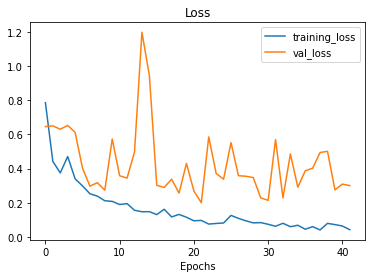

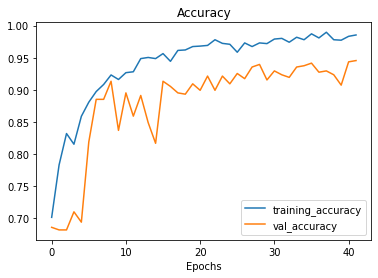

In [ ]:
# Plotting loss curves

plot_loss_curves(history_classification)

In [ ]:
 # Saving the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
model.save("classifier-resnet-model.hdf5")

In [ ]:
# Loading pretrained model
with open("resnet-50-MRI.json", "r") as json_file:
    json_savedModel= json_file.read()
# Load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights("weights.hdf5")
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

## Assessing trained classifier performance

In [ ]:
# Making predictions
test_predict = model.predict(test_generator,
                             steps=test_generator.n//16,
                             verbose=1)

36/36 [==============================] - 405s 12s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
 test_predict

array([[9.9999785e-01, 2.1733867e-06],
       [9.9836117e-01, 1.6388515e-03],
       [7.6252357e-03, 9.9237472e-01],
       ...,
       [1.0000000e+00, 9.3304324e-09],
       [1.0520633e-06, 9.9999893e-01],
       [1.5562863e-02, 9.8443711e-01]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predictions = []

for i in test_predict:
  predictions.append(str(np.argmax(i)))

predictions = np.asarray(predictions)
predictions

array(['0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '1', '0', '0',
       '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0',
       '1', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1',
       '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0',
       '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0',
       '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0',
       '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1

In [ ]:
# since we have used test generator, it limited the images to len(predict) due to batch size
original = np.asarray(test['mask'])[:len(predictions)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predictions)
accuracy

0.9826388888888888

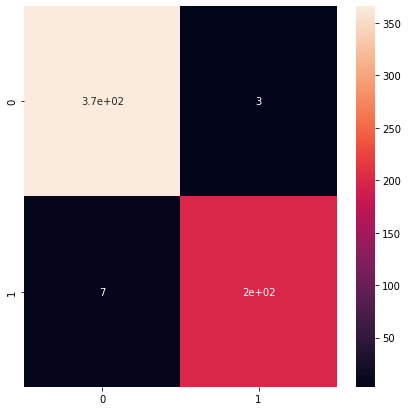

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predictions)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predictions, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       369
           1       0.99      0.97      0.98       207

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


## Building a Segmentation model to localize tumor

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# Split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# Create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
import utilities
from utilities import DataGenerator

# Create image generators
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
# Create a resblock
def resblock(X, f):


  # Make a copy of input
  X_copy = X

  # Main path

  X = Conv2D(f, kernel_size=(1,1), strides=(1,1),  kernel_initializer="he_normal")(X)
  X = BatchNormalization()(X)
  X = Activation("relu")(X)

  X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal")(X)
  X = BatchNormalization()(X)

  # Short path

  X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer="he_normal")(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation("relu")(X)

  return X

In [ ]:
# Function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
# Building the segmentation model

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16, 3, activation="relu", padding="same", kernel_initializer="he_normal")(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation="relu", padding="same", kernel_initializer="he_normal")(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output)

In [ ]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Loss Function
We need a custom loss function to train this ResUNet. So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from helper_functions import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model

adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

# Importing create_tensorboard_callback function from utilities
from helper_functions import create_tensorboard_callback

In [ ]:
history_segmentation = model_seg.fit(training_generator,
                                     epochs=100,
                                     validation_data=validation_generator,
                                     callbacks = [create_tensorboard_callback(dir_name="/content/drive/MyDrive/Brain Tumor Segmentation/training_logs",
                                                                              experiment_name="ResUNet_segmentation_model"),
                                                 checkpointer,
                                                 earlystopping])

Saving TensorBoard log files to: /content/drive/MyDrive/Brain Tumor Segmentation/training_logs/ResUNet_segmentation_model/20220614-095838
Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 0.8707 - tversky: 0.1681 
Epoch 1: val_loss improved from inf to 0.86126, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 890s 12s/step - loss: 0.8707 - tversky: 0.1681 - val_loss: 0.8613 - val_tversky: 0.1803
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 0.5889 - tversky: 0.5003
Epoch 2: val_loss improved from 0.86126 to 0.53340, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 29s 404ms/step - loss: 0.5889 - tversky: 0.5003 - val_loss: 0.5334 - val_tversky: 0.5661
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.4002 - tversky: 0.7018
Epoch 3: val_loss improved from 0.53340 to 0.51353, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 15s 206ms/step -

In [ ]:
# Modifying our function for plotting loss curves of our segmentation model
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['tversky']
  val_accuracy = history.history['val_tversky']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_focal_tversky_loss')
  plt.plot(epochs, val_loss, label='val_focal_tversky_loss')
  plt.title('Focal Tversky Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_tversky_accuracy')
  plt.plot(epochs, val_accuracy, label='val_tversky_accuracy')
  plt.title('Tversky Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

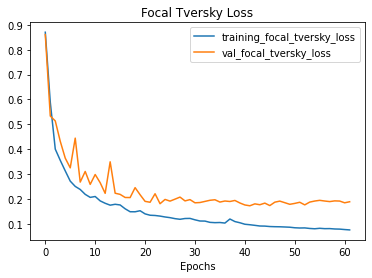

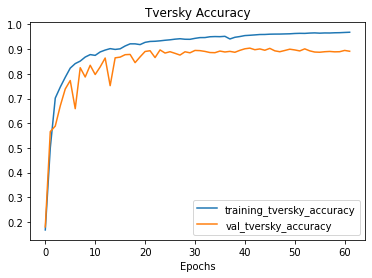

In [ ]:
# Plotting loss curves

plot_loss_curves(history_segmentation)

In [ ]:
# Save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
model_seg.save("segmentation-resunet-model.hdf5")

## Assessing trained Segmentation ResUNet model performance

In [ ]:
from helper_functions import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from helper_functions import prediction

# Making predictions
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({"image_path": image_id,"predicted_mask": mask,"has_mask": has_mask})
df_pred

image_path  \
0    TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8.tif   
1    TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_63...   
2    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58...   
3    TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12...   
4    TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18...   
..                                                 ...   
585  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_17...   
586  TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_38...   
587  TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_17...   
588  TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_48...   
589  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_7.tif   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1                                              No mask         0  
2    [[[[5.3664974e-07], [1.9516724e-06], [3.865395...         1  
3                                              No mask         0  
4    [[[[7.9917567e-07], [3.6728716e-06], [1.133503...         1  
..                                                 ...       ...  
585                                            No mask         0  
586  [[[[4.453667e-06], [7.970102e-06], [1.0840084e...         1  
587                                            No mask         0  
588                                            No mask         0  
589                                            No mask         0  

[590 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data
df_pred = test.merge(df_pred, on="image_path")
df_pred.head()

image_path  \
0  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8.tif   
1  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_63...   
2  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58...   
3  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12...   
4  TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18...   

                                           mask_path mask  \
0  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8_...    0   
1  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_63...    0   
2  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58...    1   
3  TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_12...    0   
4  TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18...    1   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2  [[[[5.3664974e-07], [1.9516724e-06], [3.865395...         1  
3                                            No mask         0  
4  [[[[7.9917567e-07], [3.6728716e-06], [1.133503...         1

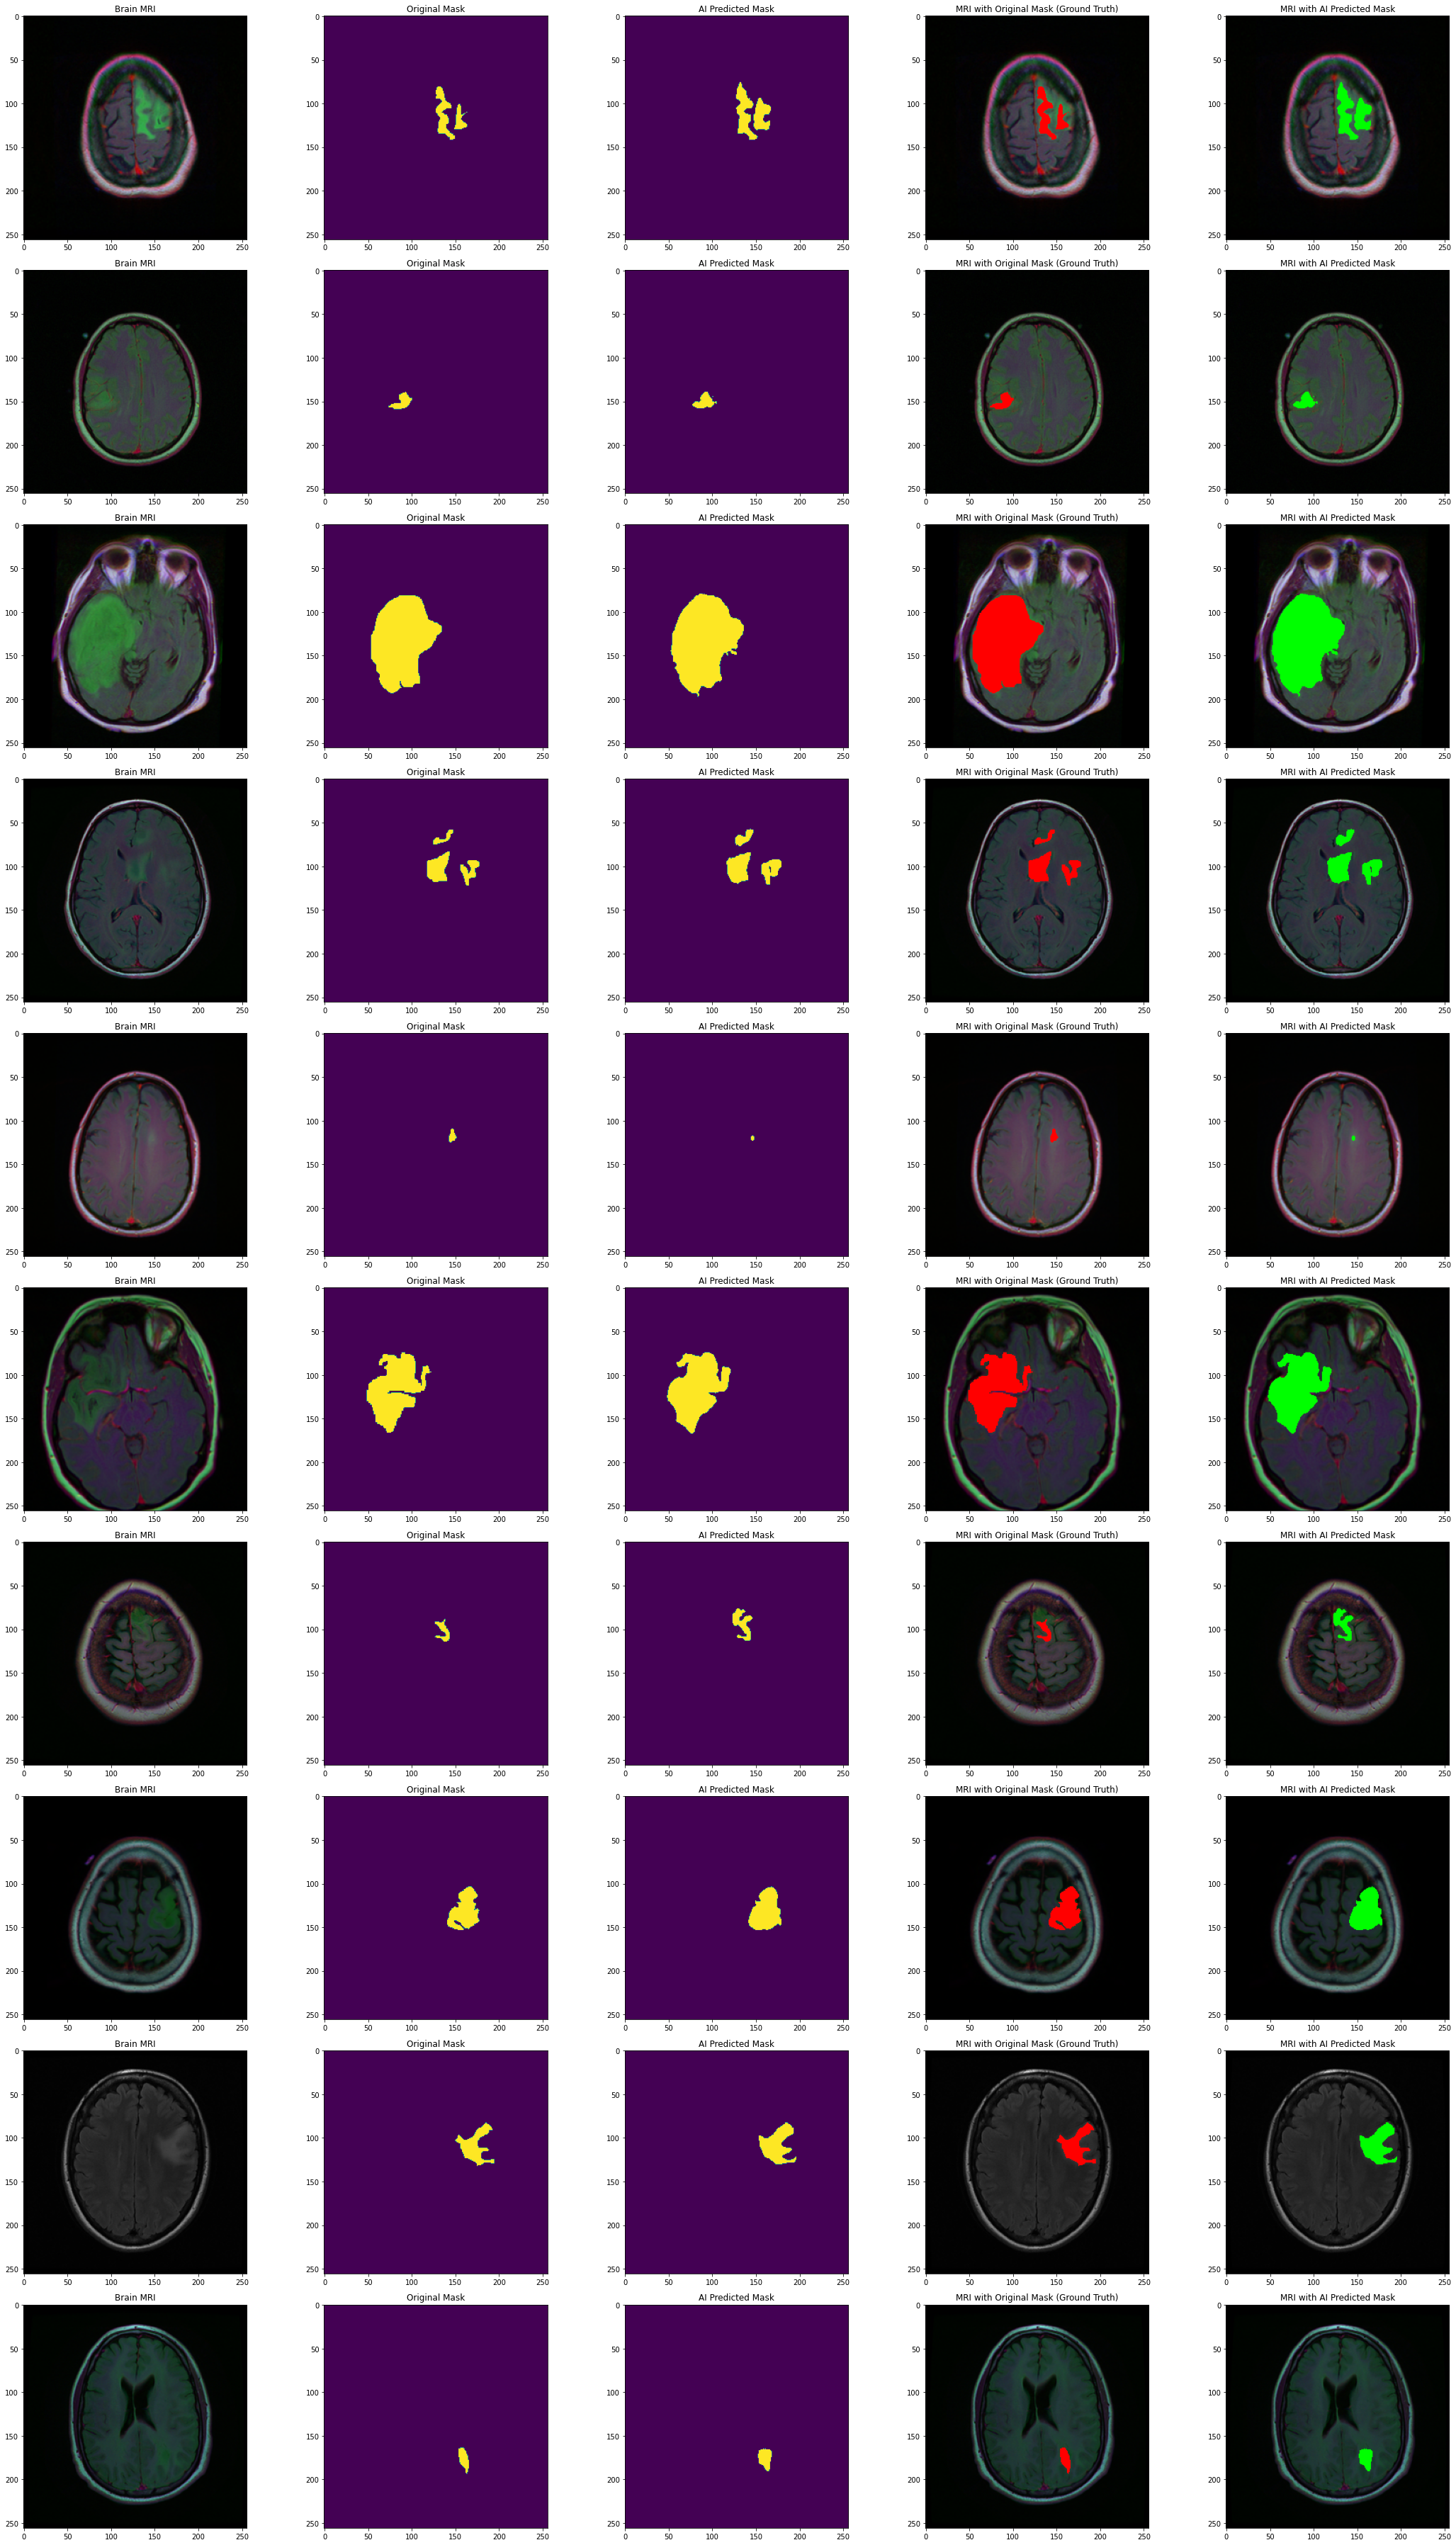

In [ ]:
# Visualizing our segmentation model's predictions

count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred["has_mask"][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

**Our segmentation model has scored an accuracy of 90.41% on the validation data.**